In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(666)

In [2]:
def arange(start, end, step):
    return np.linspace(start, end, int(np.ceil((end - start) / step) + 1))

In [3]:
def solve(d, a, b, c, lambda_a, lambda_b, lambda_c):
    if d + lambda_a + lambda_b + lambda_c <= a:
        return d + lambda_a + lambda_b + lambda_c
    elif a < d - lambda_a + lambda_b + lambda_c <= b:
        return d - lambda_a + lambda_b + lambda_c
    elif b < d - lambda_a - lambda_b + lambda_c <= c:
        return d - lambda_a - lambda_b + lambda_c
    elif c < d - lambda_a - lambda_b - lambda_c:
        return d - lambda_a - lambda_b - lambda_c
    
    return None

In [4]:
class FLSA_1D:
    __slots__ = ["__beta_tilde", "__w", "__tol", "__lambda_1", "__lambda_2"]
    
    @property
    def coef_(self):
        return np.repeat(self.__beta_tilde, self.__w)

    @property
    def beta_tilde(self):
        return self.__beta_tilde

    @property
    def weights(self):
        return self.__w
        
    def __init__(self, lambda_1=1.0, lambda_2=1.0, tol=0.0001):
        self.__beta_tilde = np.array([])
        self.__w = np.array([])

        self.__tol = tol
        
        self.__lambda_1 = lambda_1
        self.__lambda_2 = lambda_2
        
        return

    def __loss(self, beta, y, w):
        return 0.5 * (w * (y - beta) ** 2).sum() + self.__lambda_1 * (w * abs(beta)).sum() + self.__lambda_2 * (abs(beta[1:] - beta[:-1])).sum()

    def __roughly_equal(self, a, b):
        return np.linalg.norm(a - b, 2) < self.__tol

    def fit(self, y, quick=True):
        delta = 1e-9

        n = len(y)
        self.__beta_tilde = np.zeros(n)
        self.__w = np.ones(n, dtype=np.int32)

        # iterate over lambda_2
        for lambda_2 in (np.linspace(0, self.__lambda_2, 1000) if quick else arange(0, self.__lambda_2, delta)):
            # consider fusion of neighbouring parameters
            for i in range(1, len(y)):
                # fuse y_{i-1} and y_i together
                tmp_y = np.concat([
                    y[:i - 1],
                    np.array([(self.__w[i - 1] * y[i - 1] + self.__w[i] * y[i]) / (self.__w[i - 1] + self.__w[i])]),
                    y[i + 1:]
                ])
                # 
                tmp_beta_tilde = np.concat([
                    self.__beta_tilde[:i - 1],
                    np.array([0]),
                    self.__beta_tilde[i + 1:]
                ])
                # vector of weights
                tmp_w = np.concat([
                    self.__w[:i - 1],
                    np.array([self.__w[i - 1] + self.__w[i]]),
                    self.__w[i + 1:]
                ])           

                breakpoints = np.array([0, 0 if i == 1 else self.__beta_tilde[i - 2], 0 if i == len(y) - 1 else self.__beta_tilde[i + 1]])
                penalties = np.array([self.__lambda_1, 0 if i == 0 else self.__lambda_2 / tmp_w[i - 1], 0 if i == len(y) - 1 else self.__lambda_2 / tmp_w[i - 1]])
                s = np.argsort(breakpoints)
                breakpoints = breakpoints[s]
                penalties = penalties[s]

                a, b, c = breakpoints[0], breakpoints[1], breakpoints[2]
                lambda_a, lambda_b, lambda_c = penalties[0], penalties[1], penalties[2]
                
                gamma = solve(tmp_y[i - 1], a, b, c, lambda_a, lambda_b, lambda_c)

                if gamma is None:
                    min_v = float("+inf")
                    min_p = 0

                    for _breakpoint in breakpoints:
                        tmp_beta_tilde[i - 1]  = _breakpoint 
                        
                        v = self.__loss(tmp_beta_tilde, tmp_y, tmp_w)
                        if v < min_v:
                            min_v = v
                            gamma = _breakpoint

                self.__beta_tilde[i - 1] = gamma
                self.__beta_tilde[i] = gamma

            # here
            i = 1
            while i < len(y):
                # if (beta[i - 1] == beta[i] && beta[i - 1] != 0)
                if self.__roughly_equal(self.__beta_tilde[[i - 1]], self.__beta_tilde[[i]]) and not self.__roughly_equal(self.__beta_tilde[[i]], 0):
                    y = np.concat([
                        y[:i - 1], 
                        np.array([(y[i - 1] + y[i]) / 2]),
                        y[i + 1:]
                    ])
                    self.__beta_tilde = np.concat([
                        self.__beta_tilde[:i],
                        self.__beta_tilde[i + 1:]
                    ])
                    self.__w = np.concat([
                        self.__w[:i - 1],
                        np.array([self.__w[i - 1] + self.__w[i]]),
                        self.__w[i + 1:]
                    ])

                    continue

                i += 1

        return self

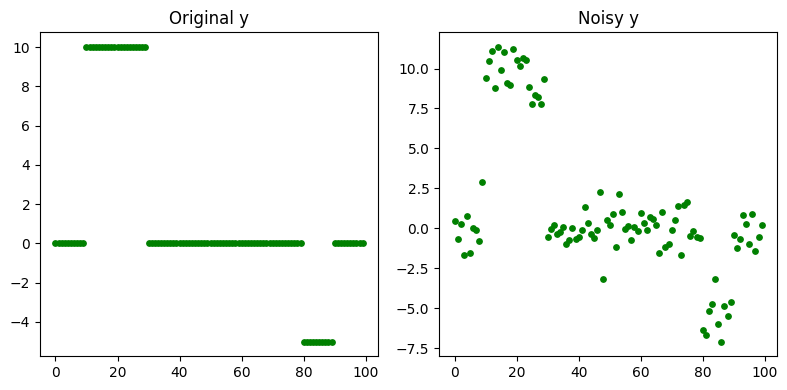

In [ ]:
np.random.seed(12)

y = np.concat([
    np.random.normal(0, 1, 10),
    np.random.normal(10, 1, 20),
    np.random.normal(0, 1, 50),
    np.random.normal(-5, 1, 10),
    np.random.normal(0, 1, 10)
])
y_original = np.concat([
    np.array([0]*10),
    np.array([10]*20),
    np.array([0]*50),
    np.array([-5]*10),
    np.array([0]*10)
])

# y_train, y_test = y[1::2], y[::2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].scatter(range(len(y)), y_original, s=15, c='green')
ax[0].set_title("Original y")
ax[1].scatter(range(len(y)), y, s=15, c='green')
ax[1].set_title("Noisy y")
plt.tight_layout()
plt.savefig("images/1D_original_and_noisy_comparison_1.png")
plt.show()

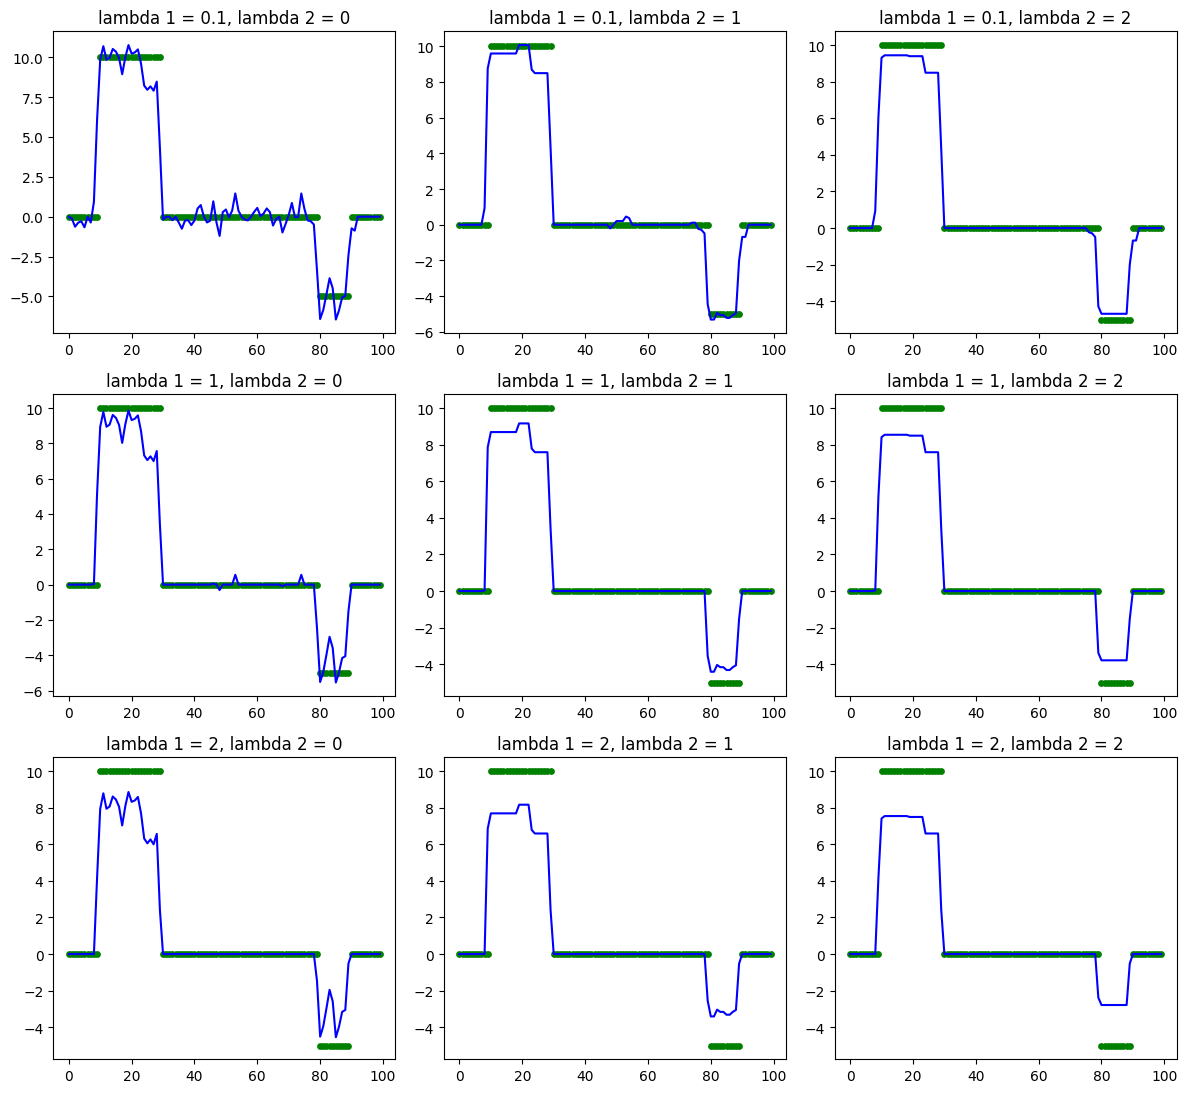

In [ ]:
lambda_1_vals = [0.1, 1, 2]
lambda_2_vals = [0, 1, 2]
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, lambda_1 in enumerate(lambda_1_vals):
    for j, lambda_2 in enumerate(lambda_2_vals):
        model = FLSA_1D(lambda_1=lambda_1, lambda_2=lambda_2).fit(y)
        ax = axs[i, j]
        ax.scatter(range(len(y)), y_original, c='green', s=15)
        ax.plot(range(len(model.coef_)), model.coef_, c='blue')
        ax.set_title(f"lambda 1 = {lambda_1}, lambda 2 = {lambda_2}")
        # ax.axis('off')

# plt.suptitle("Denoised outputs for varying lambdas", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("images/1D_denoising_lambda_comparison_1.png")
plt.show()

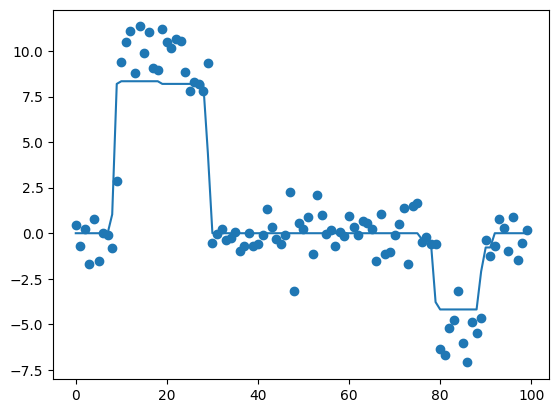

In [118]:
model = FLSA_1D(lambda_1=0, lambda_2=3.5).fit(y)

plt.plot(range(len(model.coef_)), model.coef_)
# plt.scatter(range(len(y_train)), y_train)
plt.scatter(range(len(y)), y)
plt.show()